# ITC 6001 - PROJECT - Introduction To Big Data #
## Drouvas Panagiotis, Dendrinos Theodoros, Kontoudakis Nikolaos ##

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print(os.getcwd());
# change the following on your pc!
# projectPath = "/home/nikos/Documents/6001_project"
projectPath = "./"
dataPath = projectPath + "/ml-100k/u.data"
userPath = projectPath + "/ml-100k/u.user";

#outlier sigma limit
oSL= 3

/home/nikos/Documents/6001_project


# Q1: Exploring the Data

## Read the data

In [6]:
uData = pd.read_csv(dataPath, sep= '\t', header= None, names=["userId", "itemId", "rating", "timestamp"])
uUser = pd.read_csv(userPath, sep= '|', header= None, names=['userId', 'age', 'gender', 'occupation', 'zip_code']).drop(columns =  ['occupation', 'zip_code']).set_index(keys="userId", drop= "True")
pivotedData = uData.pivot(index="userId", columns="itemId", values="rating").reset_index().rename_axis(None, axis=1).set_index(keys="userId", drop= "True")
#make it easier to access the column names
pivotedData.columns = pivotedData.columns.map(str)
# pivotedData = pivotedData.sample(frac=0.01,random_state=100, axis= 0)

In [7]:
# #free testing area

# display(pivotedData[pivotedData.userId== 916])
# pivotedData.to_csv("export.csv", sep=',', encoding='utf-8', index=False, header=True)
# diferentPivotMovies = uData.pivot(index="itemId", columns="userId", values="rating").reset_index().rename_axis(None, axis=1)
# display(pivotedData)
# print(diferentPivotMovies)

# uData[uData.userId == 943].sum()
# pivotedData.loc[[943]].sum(axis=1)

## Remove outliers ##

In [9]:
# for movies
movieRatingsCount = pivotedData.notna().sum(axis= 0)
movieRatingCountMu = np.mean(movieRatingsCount)
movieRatingSigma = np.std(movieRatingsCount)
ZMovieScore = ((movieRatingsCount - movieRatingCountMu)) / movieRatingSigma
lessThan10 = movieRatingsCount < 9

In [10]:
# for users
ratingsCount = pivotedData.notna().sum(axis= 1)
mu = np.mean(ratingsCount)
sigma = np.std(ratingsCount)
pivotedData['ZScore'] = ((ratingsCount - mu) / sigma)

#z scores for both movies and users have been calculated in advance in order to be fair.
#otherwise if we droped some users and later calculating the movie ZScore we would also drop their ratings which would result in mistakenly calculating some movies as outliers 
removedOutliers = pivotedData[(pivotedData.ZScore > -oSL) & (pivotedData.ZScore < oSL)].drop(columns= ["ZScore"])
movieOutliers = ZMovieScore[(ZMovieScore < -oSL) | (ZMovieScore > oSL)].index
lessThan10Indexes = lessThan10[lessThan10].index
# Drop the columns from the DataFrame
removedOutliers = removedOutliers.drop(columns=movieOutliers, axis=1)
removedOutliers = removedOutliers.drop(columns=lessThan10Indexes, axis=1)

## Information ##

In [12]:
removedOutliers.describe()
removedOutliers.to_csv("removedOutliers.csv", sep=',', encoding='utf-8', index=True, header=True)

## Ploting ##
 plot the number of movies seen by each user, and the frequency of each rating

(array([ 94., 121., 107.,  65.,  62.,  65.,  66.,  31.,  41.,  50.,  36.,
         19.,  35.,  28.,  21.,  22.,  11.,  13.,  19.,  18.,  24.,  14.,
          8.,  11.,  11.,  13.,   8.,  17.,  16.,   7.,   5.,   4.,   8.,
          7.,   4.,  10.,   9.,   2.,   3.,   6.,   6.,   7.,   2.,   4.,
          3.,   4.,   3.,   0.,   8.,   5.]),
 array([  4.  ,   9.74,  15.48,  21.22,  26.96,  32.7 ,  38.44,  44.18,
         49.92,  55.66,  61.4 ,  67.14,  72.88,  78.62,  84.36,  90.1 ,
         95.84, 101.58, 107.32, 113.06, 118.8 , 124.54, 130.28, 136.02,
        141.76, 147.5 , 153.24, 158.98, 164.72, 170.46, 176.2 , 181.94,
        187.68, 193.42, 199.16, 204.9 , 210.64, 216.38, 222.12, 227.86,
        233.6 , 239.34, 245.08, 250.82, 256.56, 262.3 , 268.04, 273.78,
        279.52, 285.26, 291.  ]),
 <BarContainer object of 50 artists>)

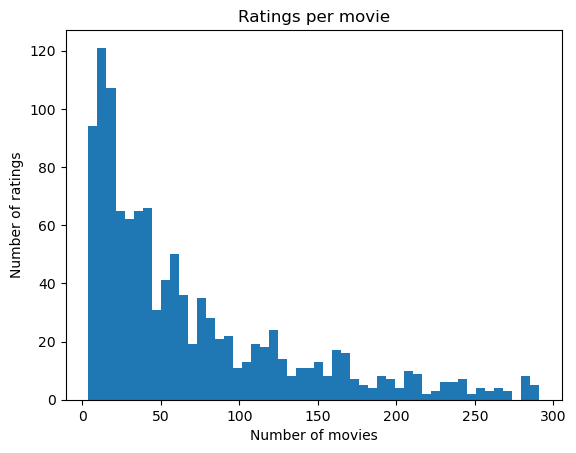

In [14]:
plt.title('Ratings per movie')
plt.xlabel("Number of movies")
plt.ylabel("Number of ratings")
plt.hist(removedOutliers.count(), bins= 50)

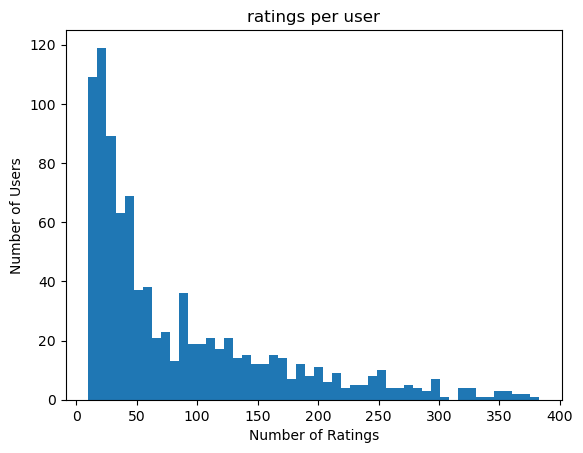

In [15]:
ratingsPerUser = removedOutliers.notnull().sum(axis=1)

ratingsPerUser.hist(bins=50)
plt.title('ratings per user')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()



# Q2: Basic Recommended System

## Spliting data into train and test ##

In [18]:
#random_state property allows for repitability of the spliting
trainData= removedOutliers.sample(frac=0.8,random_state=200, axis= 0)
testData= removedOutliers.drop(trainData.index)

In [19]:
#get the number of ratings a movie has
trainDataRatingsCount = trainData.notna().sum(axis= 0)
trainData

,2,3,4,5,6,8,9,10,11,12,...,1471,1473,1478,1480,1483,1503,1518,1540,1615,1620
userId,,,,,,,,,,,,,,,,,,,,,
797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recomend movies to test users

In [21]:
# we recommend for each user seperately in order to be more flexible with the calculations

averageMovieRating = trainData.mean().sort_values(ascending= False)
recommendedMovies = pd.DataFrame()
for userIndex, row in testData.iterrows():  
    # if we want to recomend allready seen movies
    # notNanCols = row.dropna().index
    # sortedCols = averageMovieRating[notNanCols].sort_values(ascending=False).index[:10]
    
    #recommend the top 10 movies
    sortedCols = averageMovieRating.index[:10]
    topValues = averageMovieRating[sortedCols].values
    recommendedMovies.loc[userIndex, sortedCols] = topValues

# remove the warning
pd.set_option("future.no_silent_downcasting", True)
recommendedMovies = recommendedMovies.replace(b'', np.nan)
# testData.to_csv("testData.csv", sep=',', encoding='utf-8', index=True, header=True)
# averageMovieRating.to_csv("AMR.csv", sep=',', encoding='utf-8', index=True, header=True)
# recommendedMovies.to_csv("recommended.csv", sep=',', encoding='utf-8', index=True, header=True)

# Evaluate results using MAE, RMSE, precision, recall, and F1.

In [23]:
# calculate only for the values we predicted
alignedObservedDf, alignedCalculatedDF = testData.align(recommendedMovies)
validMask = ~alignedCalculatedDF.isna()
# validMask.to_csv("validMask.csv", sep=',', encoding='utf-8', index=True, header=True)
# remove NaN values
validOriginal = alignedObservedDf[validMask]
validCalculated = alignedCalculatedDF[validMask]


## MAE

In [25]:
# mean two times for the two axis
MAE = np.abs(validOriginal - validCalculated).mean().mean()
MAE

0.6008636727920661

## RMSE

In [27]:
meanSquaredError = ((validCalculated - validOriginal) ** 2).mean().mean()
RMSE = np.sqrt(meanSquaredError)
RMSE

0.7254250170067811

In [28]:
# calculate precision and recall nominator.
# seen movies that were recommended and the user rated them > 3.
wellRated = testData[testData >= 3]
alignedWellRated, alignedRecommended = wellRated.align(recommendedMovies)
validWellRatedMask = ~alignedWellRated.isna()
validRecommended = alignedRecommended[validWellRatedMask]

## Precision

In [30]:
precision = (validRecommended.notna().sum(axis= 1)/10).mean()
precision

0.13333333333333333

## Recall

In [32]:
recall = (validRecommended.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
recall

0.020571099398505436

## F1 Score

In [34]:
f1Score = 2* ((precision* recall)/(precision+ recall))
f1Score

0.035643070241038514

# Q3: Collaborative Filtering: Recommender system

In [36]:
# new evaluation functions
def MAEQ3(OriginalData, CalculatedR,IsHidden):
    #set all other valuse to Zero (exept hedden)
    OriginalR1 = OriginalData.where(IsHidden,other = 0) 
    CalculatedR1 = CalculatedR.where(IsHidden,other = 0) 
    MAE = np.abs(OriginalR1 - CalculatedR1).mean().mean()
    return MAE

def RMSEQ3(OriginalData,CalculatedR,IsHidden):
    #set all other valuse to Zero (exept hedden)
    OriginalR1 = OriginalData.where(IsHidden,other = 0) 
    CalculatedR1 = CalculatedR.where(IsHidden,other = 0) 
    meanSquaredError = ((OriginalR1 - CalculatedR1) ** 2).mean().mean()
    return np.sqrt(meanSquaredError)

def precisionQ3(Recommended,Actual,IsHeadden,CorrectRange):
    Recommended1 = Recommended.where(IsHeadden,other = np.nan)
    Actual1= Actual.where(IsHeadden,other = np.nan)
    Difference  = np.abs(Actual1 - Recommended1) 
    wellRated = Recommended1.where(Difference <= CorrectRange)
    #actual calculation of precision
    precision = (wellRated.notna().sum(axis= 1)/10).mean()
    return precision

def recallQ3(Recommended,Actual,IsHeadden,CorrectRange):
    Recommended1 = Recommended.where(IsHeadden,other = np.nan)
    Actual1 = Actual.where(IsHeadden,other = np.nan)
    Difference  = np.abs(Actual1 - Recommended1) 
    wellRated = Recommended1.where(Difference <= CorrectRange)
    #actual calculation of recall
    recall = (Recommended1.notna().sum(axis= 1)/wellRated.notna().sum(axis= 1)).mean()
    return recall

def f1ScoreQ3(precision,recall):
    f1Score = 2 * ((precision * recall )/(precision + recall ))
    return f1Score

In [37]:
# helper function
def Hide20Data(OriginalRating,IsHideDataframe):
    #returns a dataframe with nan in evry cell that is hidden
    OriginalRating[IsHideDataframe] = np.nan

    return OriginalRating

In [38]:
#libraries 

def cosineSimilarity(u1, u2):
    # Dbg.write('\n ===============================')
    if (np.linalg.norm(u1) * np.linalg.norm(u2)) == 0 :
        # Dbg.write('\n !!!! Divide by zero !!!!!')
        return 9999999
    else:    
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))


# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

def Find20ofData2Hide(Random20Hiden):
    # Selecting a random 20% of non-NaN values and returns "True" to "hide" them (all othe valuse are false
    
    # Selecting only non-NaN values
    NonNaNValues = Random20Hiden.stack().reset_index(drop=False)
    # Calculate the number of samples to select (20% of the non-NaN values to hide)
    num_samples = int(0.2 * len(NonNaNValues))
    
    # Select a random sample of the non-NaN values
    # random_state property allows for repeatability of the splitting
    random_sample20_indices = NonNaNValues.sample(n=num_samples, random_state=200).index

    #initialize dataframe with false
    Random20Hiden = pd.DataFrame(False,index = Random20Hiden.index, columns = Random20Hiden.columns)
    
    # Set the selected values to NaN (Hide them from system)
    for idx in random_sample20_indices:
        row_idx = NonNaNValues.loc[idx, 'userId']
        col_idx = NonNaNValues.loc[idx, 'level_1']
        Random20Hiden.at[row_idx, col_idx] = True
        
    return Random20Hiden



def findKSimilar (r, k,printx =False):
    # Find the k-most similar users for each user
    #
    # r is the ratings matrix
    # k is the number of most similar users
    #
    # returns: '
    #similarUsers: contains the indices of the most similar users to each user
    # similarities: is the pairwise similarities, i.e. similarities between users
    
    # similarUsers is 2-D matrix
    similarUsers=-1*np.ones((nUsers,k))
    
    similarities=cosine_similarity(r)
       
    # for each user
    
    # find the indexes of all  users similar to i, by increasing value of similarity
    for i in range(0, nUsers):
        simUsersIdxs= np.argsort(similarities[:,i])
        
        l=0
        #find its most similar users    
        for j in range(simUsersIdxs.size-2, simUsersIdxs.size-1-k-1,-1):
            if printx :
                    print(simUsersIdxs[-k+1:],l)
            similarUsers[i,l]=simUsersIdxs[j]
            l=l+1
            
    return similarUsers, similarities

def Top5RatedMovies(UserMovies):
    # it finds average rating of each movie and returns top 5 rated movies

    #calculate average per movie
    UserMoviesAVG = UserMovies[UserMovies.notna()].sum() / UserMovies[UserMovies.notna() ].count()
    

    

In [39]:
#create test data

data = {
    'User1': [5, 2, 2, np.nan, np.nan],
    'User2': [np.nan, np.nan, np.nan, np.nan, np.nan],
    'User3': [4, 3, np.nan, np.nan, 5],
    'User4': [1, 2, np.nan, np.nan, 1],
    'User5': [1, 5, 5, np.nan, 1]
}
df = pd.DataFrame(data, index=['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5']).T

## 1.The collaborative system will be based on user similarity

In [41]:
# Predict Ratings based on wated waited sum of all users rating for the movie
def predictR(df, similarityMatrix):
    #Dbg =  open("DebugFile_predictR.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    # print(similarityMatrix)
    predictRatings = df.copy() #create a copy for predictions
    for user in df.index:
        for movie in df.columns:
            if np.isnan(df.loc[user, movie]):
                similarU = similarityMatrix[user].drop(user).dropna() #check similarity with others - delete similarity with himself and any nulls
                # similarU = similarU[similarU > 0] #keep positive similarity
                if not similarU.empty: #if similarity exists
                    weightedS = sum(df.loc[similarU.index, movie] * similarU) #calculates the waited sum of all users rating for the movie
                    #Dbg.write('\n @ ' + user + ',' + movie + ' => ' +str(weightedS))
                    similarityS = sum(similarU) #total similarities (to be used in the division)
                    predictRatings.loc[user, movie] = weightedS / similarityS #prediction based on the weighted sum of the ratings divided by the sum of the similarity scores
    #Dbg.close()
    return predictRatings

# Top x recommendations for each user
def topXrecommendations(predictRatings, x):
    recomm = {}
    for user in predictRatings.index:
        userR = predictRatings.loc[user]
        userR = userR[userR.notna()]
        topRecomm = userR.sort_values(ascending=False).head(x)
        recomm[user] = topRecomm.index.tolist()
    return recomm

## 2.User based similarity will be based on cosine similarity

In [43]:
def getUserSimilarity(user1, user2, maxAgeDiff):
    normalisedAge = 1- (user1['age'] - user2['age']) / maxAgeDiff
    if (user1.gender == user2.gender):
        return normalisedAge
    else:
        return (0.8 * normalisedAge)
    

In [44]:
# uUser
maxAge = uUser.age.max()
minAge = uUser.age.min()
maxAgeDiff =maxAge - minAge

In [45]:
def cosineSimilarity(u1, u2):
    try:
        return np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))
    except Exception:
        return 9999999

# Similarity matrix
def createSimilarityMatrix(df, userInformation = False, userRatingThreshold = 1):
    #create couple of users (all combinations) and calculate with cosin similarity all cobinations

    #Dbg =  open("DebugFile_createSimilarityMatrix.txt", "a")   # for debug file - to be deleted
    #Dbg.write('\n')
    
    similarityMatrix = pd.DataFrame(index=df.index, columns=df.index) # output
    #iterate in all combinations
    for i in df.index: 
        for k in df.index:
            #similarityMatrix.loc[i, k] = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
            if i == k:
                similarityMatrix.loc[i, k] = 1 # for the combination of the same user similarity is 1 by definition 
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => 1 by definition') # ->> to be commened
            else:
                #Dbg.write ('\n @ ' + str(i) + ',' + str(k) + ' = ' + str(similarityMatrix.loc[i, k] ) + ' => ' + str(cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0)))) # ->> to be commened
                cosineSimilatiy = cosineSimilarity(df.loc[i].fillna(0), df.loc[k].fillna(0))
                if(userInformation == False):
                     if(df.loc[k].count() < userRatingThreshold):
                         similarityMatrix.loc[i, k] = 0
                     else:
                        similarityMatrix.loc[i, k] = cosineSimilatiy
                else: 
                    if(df.loc[k].count() < userRatingThreshold):
                        similarityMatrix.loc[i, k] = 0
                    else:    
                        userSimilarity =  getUserSimilarity(uUser.loc[i], uUser.loc[k], maxAgeDiff)
                        similarityMatrix.loc[i, k] = ((cosineSimilatiy* 0.7) + (userSimilarity* 0.3))
    #Dbg.close()            
    return similarityMatrix    

## 3.Generate the top-5 recommendations per user

In [47]:
# for performance reason we will use a fraction of the data
perfFrac = 0.2

similarity_matrix = createSimilarityMatrix(removedOutliers.sample(frac= perfFrac,random_state=200, axis= 0))

In [48]:
predicted_ratings = predictR(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), similarity_matrix) 

In [49]:
top_recommendations = topXrecommendations(predicted_ratings, 5)

## 4.Evaluation

### a. Randomly hide 20% of the interactions’ matrix (users in rows, movies in columns). That is hide 20% of the cells.

In [52]:
hiddenData = Find20ofData2Hide(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0))
hiddenData.to_csv('hiddenValuesExport.csv')

def getPredictionData(similarity_matrix, data, neighbhours):
    predictionData = pd.DataFrame()
    for index, row in hiddenData.iterrows():
        # Check if any value in the row is True
        if row.any():  
            # row.idxmax()  
            similarUserIds = similarity_matrix[index].drop(index = index).sort_values(ascending = False).head(neighbhours)
            similarUsers = data.loc[pd.Series(similarUserIds.index.values)]
            predictionData.loc[index, row.idxmax()] = similarUsers[row.idxmax()].dropna().mean()
    return predictionData
    
predictionData = getPredictionData(similarity_matrix, removedOutliers, 5)

### Evaluate the prediction

In [54]:
maeRecs2= MAEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), predictionData,hiddenData)
print(maeRecs2)
rmseRecs2= RMSEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), predictionData,hiddenData)
print(rmseRecs2)

# preRecs2 = precisionQ3(predictionData, removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), hiddenData, 0.5)
# print(preRecs2)
# recallRecs2= recallQ3(predictionData,removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), hiddenData, 0.5)
# print(recallRecs2)
# f1Recs2 = f1ScoreQ3(precisionQ3, recallRecs2)
# print(f1Recs2)

0.010070865395475885
0.1272763010469303


# Q4: Improvements:

## Introduction of user data

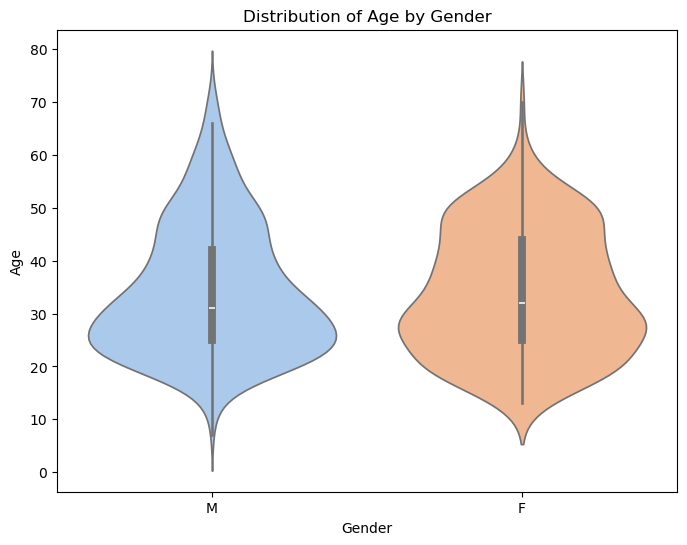

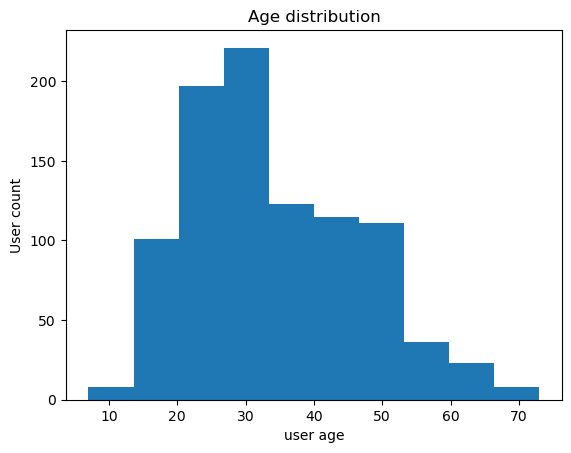

In [57]:
# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='gender', y='age', data=uUser, palette='pastel', legend=False, hue = 'gender')

# Add titles and labels
plt.title('Distribution of Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

plt.hist(uUser.drop(columns = 'gender'))
plt.title('Age distribution')
plt.ylabel('User count')
plt.xlabel('user age')
plt.show()

### Tune hyperparameters of your models

In [59]:
best_rmse = 99999999
best_neighbhor_count = 0
resultsDf = pd.DataFrame(columns = ['neighbhors', 'rmse'])
for i in range(2, 20):
    result = getPredictionData(similarity_matrix, removedOutliers, i)
    rmse = RMSEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), result, hiddenData)
    resultsDf = pd.concat([pd.DataFrame([[i, rmse]], columns=resultsDf.columns), resultsDf], ignore_index=True)
    if(rmse < best_rmse):
        best_rmse = rmse
        best_neighborh_count = i

resultsDf

/tmp/ipykernel_41056/3604579377.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultsDf = pd.concat([pd.DataFrame([[i, rmse]], columns=resultsDf.columns), resultsDf], ignore_index=True)


,neighbhors,rmse
0,19,0.122524
1,18,0.122654
2,17,0.121814
3,16,0.119289
4,15,0.118659
5,14,0.118868
6,13,0.118866
7,12,0.120014
8,11,0.121402
9,10,0.121053


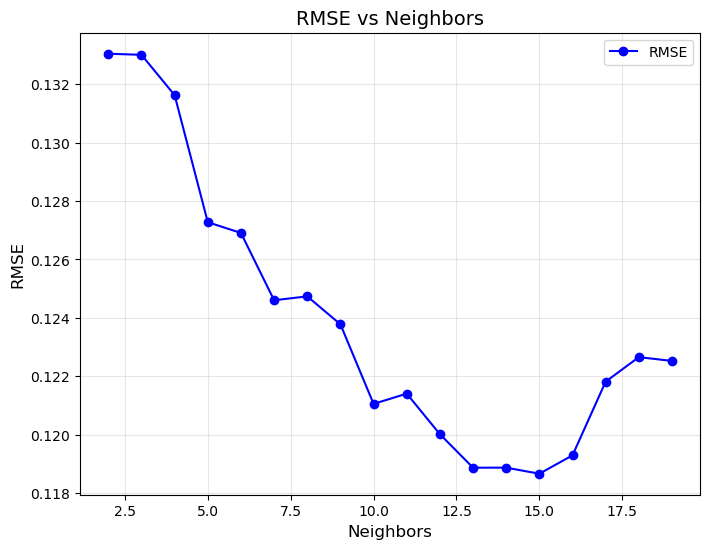

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(resultsDf['neighbhors'], resultsDf['rmse'], marker='o', linestyle='-', color='b', label='RMSE')

plt.title('RMSE vs Neighbors', fontsize=14)
plt.xlabel('Neighbors', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

#we conclude that by increasing the neighbhors we have better accuracy that starts to diminish around 13 neighborhs (cpu time vs result)

### Experiment with different user thresholds

In [62]:
similarity_matrix_with_threshold = createSimilarityMatrix(removedOutliers.sample(frac= perfFrac,random_state=200, axis= 0), userInformation = False, userRatingThreshold= 20)
#we use the new optimised neighbhor count 
improvedPredictionData= getPredictionData(similarity_matrix_with_threshold, removedOutliers, 13)

In [63]:
maeRecs3= MAEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), improvedPredictionData,hiddenData)
print('Mean average error is: ', maeRecs3)
rmseRecs3= RMSEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), improvedPredictionData,hiddenData)
print('Room mean square error is: ', rmseRecs3)

Mean average error is:  0.00955951553544332
Room mean square error is:  0.11672090891533739


### Additional Features

In [65]:
similarity_matrix_with_users = createSimilarityMatrix(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), userInformation = True)
similarity_matrix_with_users_and_threshold = createSimilarityMatrix(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), userInformation = True, userRatingThreshold= 20)
resultWithUsers = getPredictionData(similarity_matrix_with_users, removedOutliers, 13)
resultWithAllInfo = getPredictionData(similarity_matrix_with_users_and_threshold, removedOutliers, 13)

In [66]:
maeRecs4= MAEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), resultWithUsers, hiddenData)
print('Mean average error is: ', maeRecs4)
rmseRecs4= RMSEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), resultWithUsers, hiddenData)
print('Room mean square error is: ', rmseRecs4)

maeRecs5= MAEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), resultWithAllInfo, hiddenData)
print('Mean average error is: ', maeRecs5)
rmseRecs5= RMSEQ3(removedOutliers.sample(frac= perfFrac, random_state=200, axis= 0), resultWithAllInfo, hiddenData)
print('Room mean square error is: ', rmseRecs5)

Mean average error is:  0.010135997895537312
Room mean square error is:  0.12539046704137904
Mean average error is:  0.00991517328497744
Room mean square error is:  0.12416746049084812


### Imporvements comparison

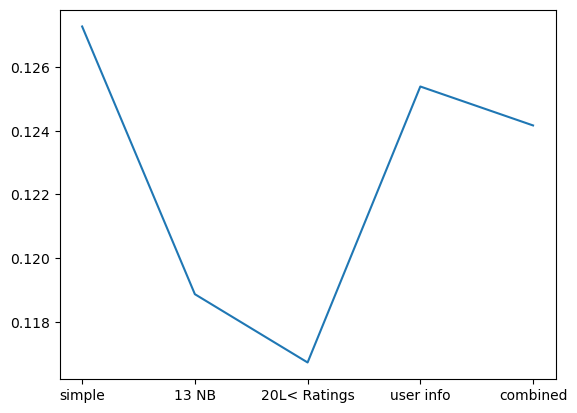

In [68]:
comparisonData = [rmseRecs2, resultsDf.iloc[6].rmse, rmseRecs3, rmseRecs4, rmseRecs5]
plt.plot(['simple', '13 NB', '20L< Ratings', 'user info', 'combined'], comparisonData)
plt.show()